In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)

In [2]:
# Origination wrangling
origination_data_file = "~/Desktop/Figure/historical_data1_2009/historical_data1_Q12009/historical_data1_Q12009.txt"
origination_names = ["fico",
                     "first_payment_date",
                     "is_first_time_home_buyer",
                     "maturity_date",
                     "msa",
                     "mort_ins_pct",
                     "num_units",
                     "occpy_sts",
                     "cltv",
                     "dti",
                     "orig_upb",
                     "ltv",
                     "interest_rate",
                     "channel",
                     "is_ppmt_pnlty",
                     "prod_type",
                     "state",
                     "prop_type",
                     "zipcode",
                     "id_loan",
                     "loan_purpose",
                     "orig_loan_term",
                     "num_borr",
                     "seller_name",
                     "servicer_name",
                     "is_super_conforming"]

origination = pd.read_csv(origination_data_file,
                          header=None,
                          delimiter='|',
                          names=origination_names,
                          index_col='id_loan',
                          na_values={'fico': 9999,
                                     'is_first_time_home_buyer': 9,
                                     'mort_ins_pct': 999,
                                     'num_units': 99,
                                     'occpy_sts': 9,
                                     'cltv': 999,
                                     'dti': 999,
                                     'ltv': 999,
                                     'channel': 9,
                                     'prop_type': 99,
                                     'loan_purpose': 9,
                                     'num_borr': 99})\
    .drop(columns=['first_payment_date',
                   'maturity_date',
                   'prod_type',
                   'seller_name',
                   'servicer_name'])

print(f"Shape of dataset is {origination.shape}")

Shape of dataset is (587404, 20)


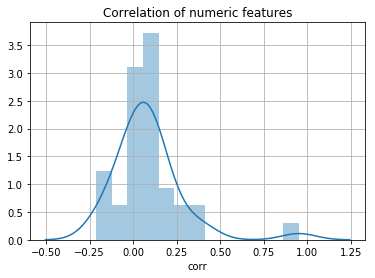

In [3]:
# Examine correlation of numeric features
numeric_features = ['fico',
                    'mort_ins_pct',
                    'num_units',
                    'cltv',
                    'dti',
                    'orig_upb',
                    'ltv',
                    'interest_rate',
                    'orig_loan_term']

corr_ = origination[numeric_features].corr().stack().reset_index()\
    .sort_values(by=0, ascending=False)\
    .rename(columns={0: 'corr'})
corr_ = corr_[corr_.level_0 != corr_.level_1]
corr_['feature_pair'] = corr_[['level_0', 'level_1']]\
    .apply(lambda r: "_".join(sorted([r['level_0'], r['level_1']])), axis=1)
corr_ = corr_[['feature_pair', 'corr']].drop_duplicates()

sns.distplot(corr_['corr'])
plt.title('Correlation of numeric features')
plt.grid()

In [4]:
print(corr_)
# Note that cltv and ltv are highly correlated 0.952995. Will (mostly likely) need to eliminate one

                    feature_pair      corr
57                      cltv_ltv  0.952995
15              ltv_mort_ins_pct  0.406588
12             cltv_mort_ins_pct  0.382309
79  interest_rate_orig_loan_term  0.281022
77       orig_loan_term_orig_upb  0.239303
35           cltv_orig_loan_term  0.170972
78            ltv_orig_loan_term  0.163207
31                      cltv_dti  0.149385
58                       dti_ltv  0.144936
69             interest_rate_ltv  0.129715
66            cltv_interest_rate  0.119918
41                  dti_orig_upb  0.118037
32                 cltv_orig_upb  0.116530
73   mort_ins_pct_orig_loan_term  0.094724
67             dti_interest_rate  0.094139
76            dti_orig_loan_term  0.093862
25       interest_rate_num_units  0.084283
51                  ltv_orig_upb  0.073345
64    interest_rate_mort_ins_pct  0.069935
37              dti_mort_ins_pct  0.058410
22                 dti_num_units  0.048403
23            num_units_orig_upb  0.019071
5          

In [5]:
# Print number of missing observations
print("Number of missing observations for each numeric feature:")
print(origination[numeric_features].isna().sum())

Number of missing observations for each numeric feature:
fico                25
mort_ins_pct         5
num_units            0
cltv                33
dti               2602
orig_upb             0
ltv                 15
interest_rate        0
orig_loan_term       0
dtype: int64


In [6]:
# One-hot encoding of categorical features
category_features = ['is_first_time_home_buyer',
                     'channel',
                     'is_ppmt_pnlty',
                     'prop_type',
                     'msa',
                     'occpy_sts',
                     'state',
                     'zipcode',
                     'loan_purpose',
                     'num_borr',
                     'is_super_conforming']

for col in category_features:
    new_col = origination[col].astype('category')
    if len(new_col[new_col.isna()]) > 0:
        dumm = pd.get_dummies(new_col, prefix=col, drop_first=True, dummy_na=True)
    else:
        dumm = pd.get_dummies(new_col, prefix=col, drop_first=True)
    for coll in dumm.columns:
        origination[coll] = dumm[coll]
    del origination[col]
    
print(origination.iloc[:5, :30]) 

               fico  mort_ins_pct  num_units  cltv   dti  orig_upb   ltv  interest_rate  orig_loan_term  is_first_time_home_buyer_Y  \
id_loan                                                                                                                               
F109Q1000001  776.0           0.0          1  80.0  21.0    274000  80.0          4.750             360                           0   
F109Q1000002  771.0           0.0          1  53.0  16.0    144000  53.0          4.875             360                           0   
F109Q1000003  731.0           0.0          1  28.0  10.0    154000  28.0          4.875             360                           0   
F109Q1000004  755.0           0.0          1  95.0  28.0    140000  80.0          4.875             360                           0   
F109Q1000005  732.0          12.0          1  88.0  34.0    384000  88.0          5.250             360                           0   

              is_first_time_home_buyer_nan  channel_C 

In [7]:
# Look at kernel density plots of all numeric features

plot_flag = False
if plot_flag:
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    sns.distplot(origination[~origination['fico'].isna()]['fico'], ax=axes[0, 0])
    axes[0, 0].set_xlabel('fico')
    axes[0, 0].grid()

    sns.distplot(origination[~origination['mort_ins_pct'].isna() & (origination.mort_ins_pct != 0)]['mort_ins_pct'], ax=axes[0, 1])
    axes[0, 1].set_xlabel('mort_ins_pct')
    axes[0, 1].grid()

    sns.distplot(origination[~origination['cltv'].isna()]['cltv'], ax=axes[0, 2])
    axes[0, 2].set_xlabel('cltv')
    axes[0, 2].grid()

    sns.distplot(origination[~origination['dti'].isna()]['dti'], ax=axes[1, 0])
    axes[1, 0].set_xlabel('dti')
    axes[1, 0].grid()

    sns.distplot(origination[~origination['ltv'].isna()]['ltv'], ax=axes[1, 1])
    axes[1, 1].set_xlabel('ltv')
    axes[1, 1].grid()

    sns.distplot(origination[~origination['interest_rate'].isna()]['interest_rate'], ax=axes[1, 2])
    axes[1, 2].set_xlabel('interest_rate')
    axes[1, 2].grid()

    sns.distplot(origination[~origination['num_units'].isna()]['num_units'], ax=axes[2, 0])
    axes[2, 0].set_xlabel('num_units')
    axes[2, 0].grid()

    sns.distplot(origination[~origination['orig_upb'].isna()]['orig_upb'], ax=axes[2, 1])
    axes[2, 1].set_xlabel('orig_upb')
    axes[2, 1].grid()

    sns.distplot(origination[~origination['orig_loan_term'].isna()]['orig_loan_term'], ax=axes[2, 2])
    axes[2, 2].set_xlabel('orig_loan_term')
    axes[2, 2].grid()

    fig.suptitle('Distribution of numeric features')
    fig.savefig('/Users/bethanybaker/Desktop/Figure/2019-04-17_Feature-Distributions.png')
    plt.close(fig)

In [8]:
# Performance wrangling
monthly_performance_data_file = \
    "~/Desktop/Figure/historical_data1_2009/historical_data1_Q12009/historical_data1_time_Q12009.txt"
performance_names = ["id_loan",
                     "monthly_reporting_period",
                     "current_upb",
                     "delq_sts",
                     "loan_age",
                     "mths_remng",
                     "repch_flag",
                     "flag_mod",
                     "cd_zero_bal",
                     "dt_zero_bal",
                     "current_int_rt",
                     "non_int_brng_upb",
                     "dt_lst_pi",
                     "mi_recoveries",
                     "net_sale_proceeds",
                     "non_mi_recoveries",
                     "expenses",
                     "legal_costs",
                     "maint_pres_costs",
                     "taxes_ins_costs",
                     "misc_costs",
                     "actual_loss",
                     "modcost",
                     "stepmod_ind",
                     "dpm_ind",
                     "eltv"]
print("Loading performance data...")
st = datetime.now()
performance = pd.read_csv(monthly_performance_data_file,
                          header=None,
                          delimiter="|",
                          names=performance_names,
                          usecols=['id_loan', 'delq_sts'],
                          dtype={'delq_sts': str})
print(f"time to load performance data: {datetime.now() - st}")
print(f"shape of performance data {performance.shape}")
print(performance.head())
# time to load performance data: 0:00:28.102428 (for example)

Loading performance data...
time to load performance data: 0:00:27.302915
shape of performance data (29902999, 2)
        id_loan delq_sts
0  F109Q1000001        0
1  F109Q1000001        0
2  F109Q1000001        0
3  F109Q1000001        0
4  F109Q1000001        0


In [9]:
# data wrangling & munging
# define is_deliquent at having a deliquent status of greater than or equal to 3 months

df_2 = performance.groupby('id_loan').tail(1)
df_3 = df_2[df_2.delq_sts != 'R'].copy()
df_3.delq_sts = df_3.delq_sts.astype(int)
df_3['is_deliquent'] = df_3.delq_sts.apply(lambda x: 1 if x >= 3 else 0)
df_3.set_index('id_loan', inplace=True)

# Add target variable (is_deliquent) to feature dataset (origination)
df_4 = pd.merge(origination, df_3['is_deliquent'], left_index=True, right_index=True)\
    .set_index('is_deliquent', append=True)

print(df_4.iloc[:5, :5])

                            fico  mort_ins_pct  num_units  cltv   dti
id_loan      is_deliquent                                            
F109Q1000001 0             776.0           0.0          1  80.0  21.0
F109Q1000002 0             771.0           0.0          1  53.0  16.0
F109Q1000003 0             731.0           0.0          1  28.0  10.0
F109Q1000004 0             755.0           0.0          1  95.0  28.0
F109Q1000005 0             732.0          12.0          1  88.0  34.0


In [10]:
# look at roc auc for numeric/continuous features
roc_auc_ = df_4[numeric_features].dropna()
tgt = roc_auc_.index.get_level_values(1)
roc_auc_ = roc_auc_.apply(lambda clmn: roc_auc_score(tgt, clmn)).sort_values(ascending=False)
print('roc auc values:')
print(roc_auc_)
# Cltv slightly lower than ltv
numeric_features.remove('cltv')

roc auc values:
dti               0.689641
interest_rate     0.661880
ltv               0.640549
cltv              0.640479
orig_loan_term    0.568520
mort_ins_pct      0.536265
num_units         0.512108
orig_upb          0.492789
fico              0.275149
dtype: float64


                            mutual_info  mutual_info_pct  variance  variance_pct   kount
num_borr_2.0                   0.001083         1.000000  0.229381      0.926247  376282
loan_purpose_N                 0.000253         0.233968  0.243863      0.984726  338131
state_FL                       0.000204         0.188695  0.026831      0.108344   16132
channel_R                      0.000173         0.159482  0.247646      1.000000  320700
loan_purpose_P                 0.000122         0.112931  0.106574      0.430348   70909
is_ppmt_pnlty_nan              0.000106         0.098191  0.004895      0.019766    2876
state_CA                       0.000093         0.085950  0.092324      0.372806   60170
is_first_time_home_buyer_Y     0.000089         0.082651  0.035374      0.142841   21470
state_NY                       0.000075         0.069165  0.026897      0.108612   16173
zipcode_48200                  0.000064         0.059101  0.000258      0.001043     151
state_NJ             

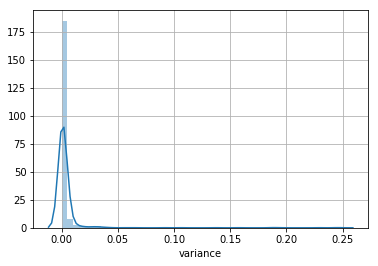

In [11]:
# look at variance & mutual information of discrete features and target
_ = pd.read_csv("~/Desktop/Figure/Figure_mutual_information.csv", index_col=0)
# print("computing mutual information of discrete features...")
# st_0 = datetime.now()
# target = df_4.index.get_level_values(1).values
# discrete_features = df_4.loc[:, "is_first_time_home_buyer_Y":]
# _ = pd.DataFrame(index=discrete_features.columns, columns=['mutual_info'])
# _['mutual_info'] = mutual_info_classif(discrete_features, target, discrete_features=True)
# _['mutual_info_pct'] = _['mutual_info']/_.mutual_info.max()
# _['variance'] = discrete_features.var()
# _['variance_pct'] = _.variance/_.variance.max()
# _['kount'] = df_4[_.index].sum()
# print(f"time to compute mutual information = {datetime.now() - st_0}")

# Look at features with maximum mutual information
_.sort_values('mutual_info', inplace=True, ascending=False)
print(_.head(20))

sns.distplot(_.variance)
plt.grid()

# Save because this takes a long time to run
# _.to_csv("~/Desktop/Figure/Figure_mutual_information.csv")

In [12]:
print(df_4.index.get_level_values(1).value_counts(normalize=True) * 100)
# Very imbalanced dataset (only 0.73% deliquent)
# AKA 4253 out of 580404

0    99.272565
1     0.727435
Name: is_deliquent, dtype: float64


In [13]:
# Keep features w/variance_pct >= x% & mutual_info >= y%
# 57 cols 5%
# 126 cols 2%
# 259 cols 1%
_VARIANCE_THRESH = 0.05
cols_to_use = list(_[(_.variance_pct >= _VARIANCE_THRESH) &
                     (_.mutual_info_pct >= 0)].index.values) + numeric_features
print(f"for variance thresh of {_VARIANCE_THRESH}, there are {len(cols_to_use)} columns")
df_5 = df_4[cols_to_use]


for variance thresh of 0.05, there are 57 columns


In [14]:
# Modeling - sample data at first
_FRACTION = 0.5
df_6 = df_5.dropna().sample(frac=_FRACTION)
print(f"Sampling fraction of {_FRACTION}")
X, y = df_6, df_6.index.get_level_values(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
vals = df_6.index.get_level_values(1).value_counts().values
scale_pos_weight = vals[0]/vals[1]
print(f"scale factor = {scale_pos_weight:.2f}")


Sampling fraction of 0.5
scale factor = 134.17


In [15]:
# Build xgboost model
_FACTOR = 1
alg = XGBClassifier(objective='binary:logistic',
                    scale_pos_weight=scale_pos_weight * _FACTOR)

st_2 = datetime.now()
print(f"current time is {st_2}")
alg.fit(X_train, y_train, eval_metric='auc')
print(f"time to train xgboost model: {datetime.now() - st_2}")
# for variance thresholding of 0.05
# 57 columns
# 2:24.559159 for frac=0.75
# for variance thresholding of 0.04
# 2:00.148950 for frac=0.5
# for variance thresholding of 0.01
# 3:56.082855 for frac=0.25
# for variance thresholding of 0.02
# 5:27.515833 for frac=0.75
# 4:27.912570 for frac=0.5
# 1:15.503807 for frac=0.25

current time is 2019-05-03 05:19:04.036294
time to train xgboost model: 0:01:15.365170


In [16]:
# Examine predictions
predictions = alg.predict(X_test)
pred_proba = alg.predict_proba(X_test)[:, 1]
print(f"confusion matrix:\n {round(pd.crosstab(predictions, y_test, normalize=True)*100, 2)}")
print(f"accuracy score : {accuracy_score(y_test, predictions):.2f}")
print(f"roc auc score: {roc_auc_score(y_test, pred_proba):.2f}")
print(f"f1 score: {f1_score(y_test, predictions):.2f}")

confusion matrix:
 col_0      0     1
row_0             
0      73.68  0.20
1      25.55  0.58
accuracy score : 0.74
roc auc score: 0.83
f1 score: 0.04


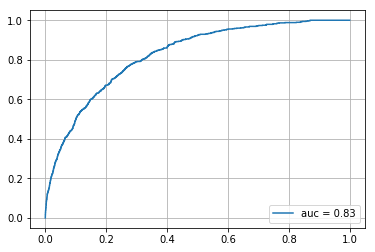

In [17]:
# Examine ROC curve
fpr, tpr, nope = roc_curve(y_test,  pred_proba)
auc = roc_auc_score(y_test, pred_proba)
plt.plot(fpr, tpr, label=f"auc = {auc:.2f}")
plt.grid()
plt.legend(loc=4)
plt.show()

In [26]:
# Examine feature importances given by model
feat_imp = alg.feature_importances_
feat = X_train.columns
res_df = pd.DataFrame({'feature': feat, 'feature_importance': feat_imp})\
    .sort_values(by='feature_importance', ascending=False)

res_df = pd.merge(res_df, _, left_on='feature', right_index=True, how='left')
res_df = pd.merge(res_df,
                  roc_auc_.to_frame(name='roc_auc').reset_index().rename(columns={'index': 'feature'}),
                  on='feature',
                  how='left')
res_df = res_df[['feature', 'feature_importance', 'mutual_info_pct', 'variance_pct', 'kount', 'roc_auc']]
print(res_df)

                         feature  feature_importance  mutual_info_pct  variance_pct     kount   roc_auc
0                           fico            0.106943              NaN           NaN       NaN  0.275149
1                   num_borr_2.0            0.095404         1.000000      0.926247  376282.0       NaN
2                            dti            0.071039              NaN           NaN       NaN  0.689641
3                 orig_loan_term            0.061034              NaN           NaN       NaN  0.568520
4                            ltv            0.049008              NaN           NaN       NaN  0.640549
5                  interest_rate            0.043888              NaN           NaN       NaN  0.661880
6                       state_CA            0.033557         0.085950      0.372806   60170.0       NaN
7                       state_FL            0.032832         0.188695      0.108344   16132.0       NaN
8                       state_WA            0.027758         0.0

In [19]:
# Discussion & questions